In [67]:
from warnings import filterwarnings

In [68]:
filterwarnings("ignore")

S&P 500 — фондовый индекс, в корзину которого включено 505 акций 500 избранных торгуемых на фондовых биржах США

In [69]:
import pandas as pd

data = pd.read_csv("ghana_gdp.zip", parse_dates=["year"], index_col=["year"])
data = data.rename(columns={'GDP (current US$)':'gdp'})
data.head()

,gdp
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


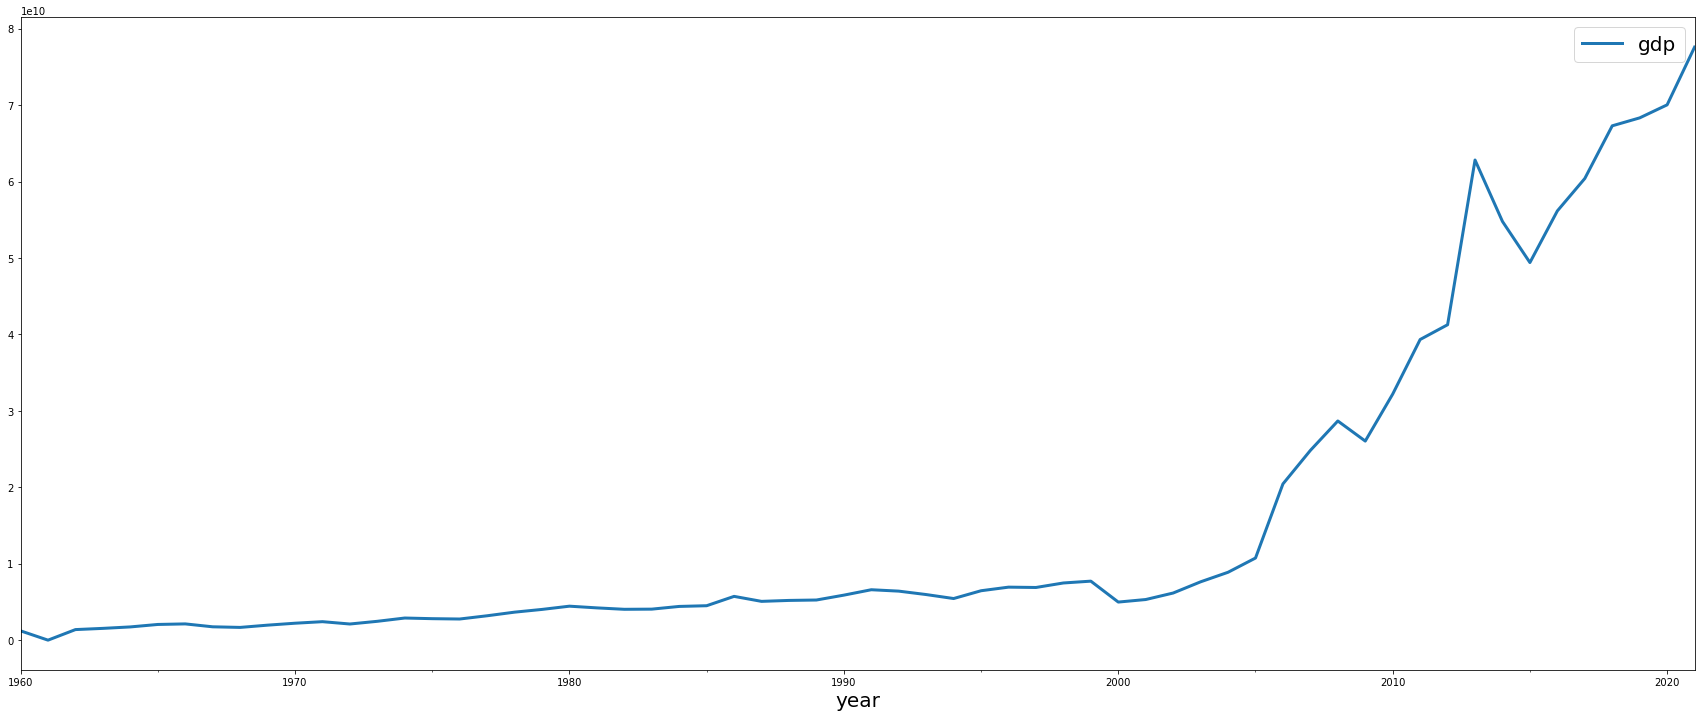

In [70]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

data.plot()
plt.show()

In [71]:
train_df = data.iloc[:-3]
test_df = data.iloc[-3:]
train_df.shape, test_df.shape

((59, 1), (3, 1))

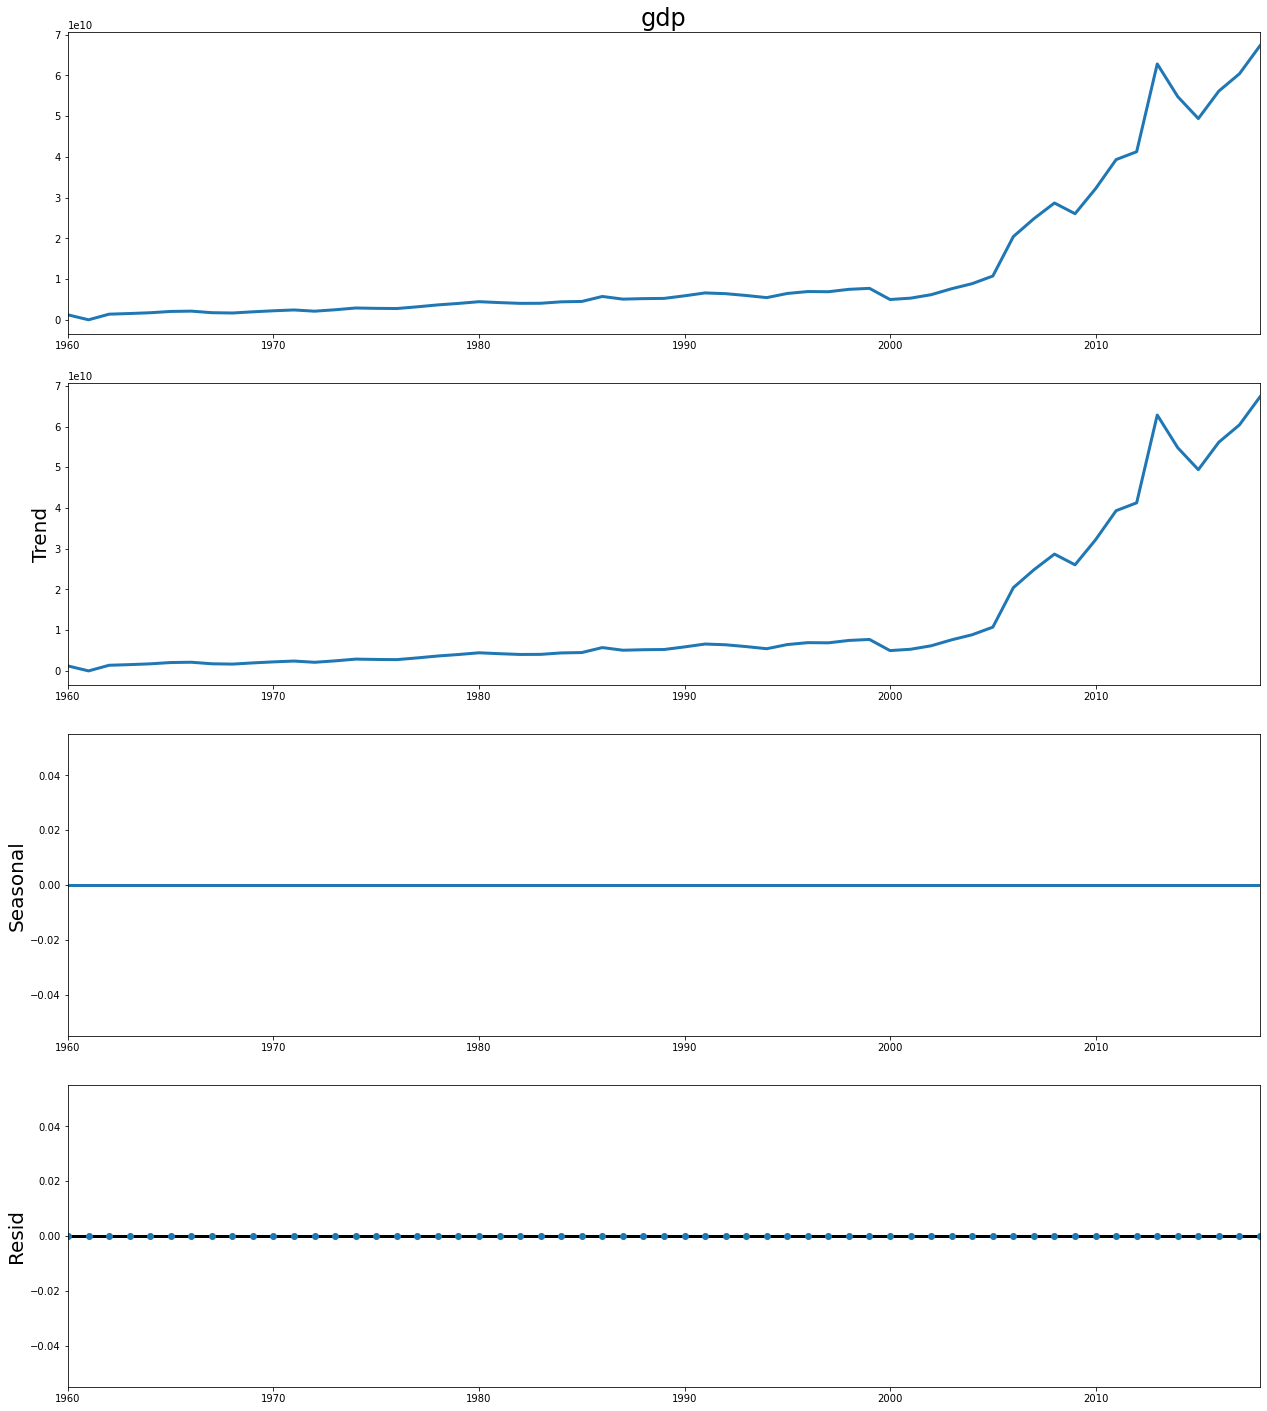

In [72]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(train_df.gdp)
result.plot()
plt.show()

Сезонная компонента выглядит очень странно, посмотрим на первые 20 значений

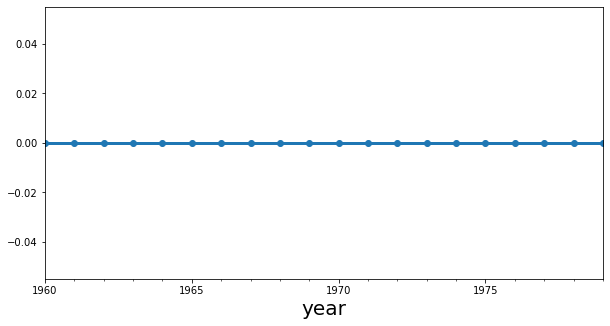

In [73]:
plt.rcParams["figure.figsize"] = 10, 5
result.seasonal[:20].plot(marker="o")
plt.show()

График четко показывает повторяющийся цикл каждые 5 периодов. Это довольно логично, поскольку наши данные — это данные о ценах на акции. Мы наблюдаем и собираем данные о ценах на акции каждый рабочий день недели. Это означает, что данные представляли собой еженедельную сезонность, а неделя была рабочей неделей (5 дней в неделю)

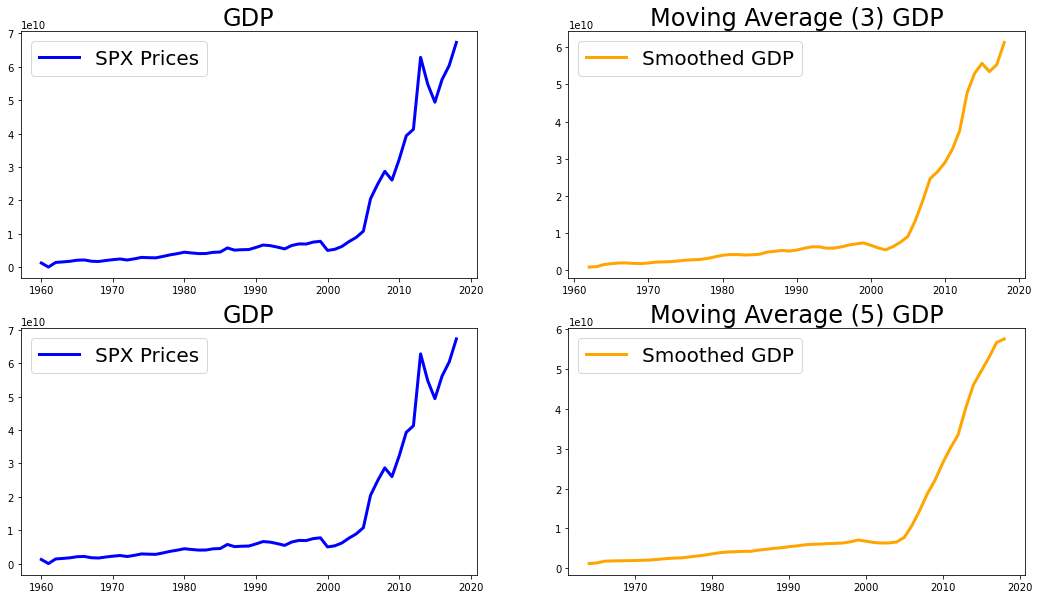

In [74]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(2, 2)

# Окно в 3 года (Window = 3)
ax[0, 0].plot(train_df.gdp, color="blue", label="SPX Prices")
ax[0, 0].set_title("GDP", size=24)
ax[0, 0].legend()

ax[0, 1].plot(
    train_df.gdp.rolling(window=3).mean(),
    color="orange",
    label="Smoothed GDP",
)

ax[0, 1].set_title("Moving Average (3) GDP", size=24)
ax[0, 1].legend()


# Окно в 5 лет (Window = 5)
ax[1, 0].plot(train_df.gdp, color="blue", label="SPX Prices")
ax[1, 0].set_title("GDP", size=24)
ax[1, 0].legend()

ax[1, 1].plot(
    train_df.gdp.rolling(window=5).mean(),
    color="orange",
    label="Smoothed GDP",
)

ax[1, 1].set_title("Moving Average (5) GDP", size=24)
ax[1, 1].legend()

plt.show()

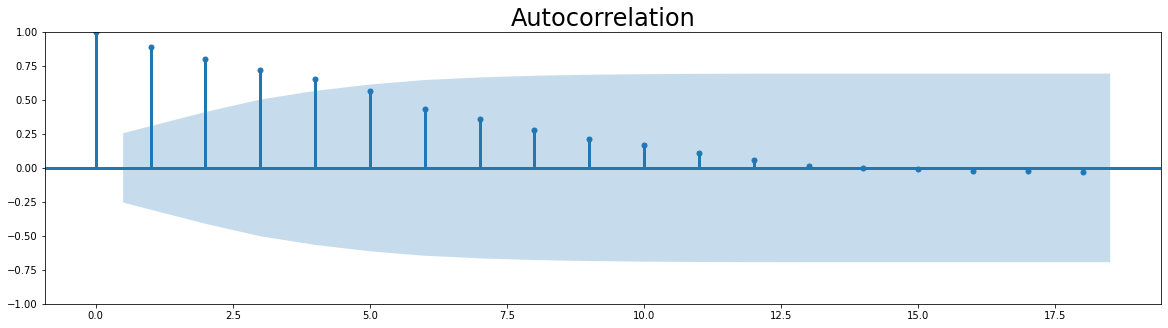

In [75]:
import statsmodels.graphics.tsaplots as sgt

plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(train_df.gdp)
plt.show()

цены SPX сильно коррелированы. Корреляция сохраняется даже по прошествии года.

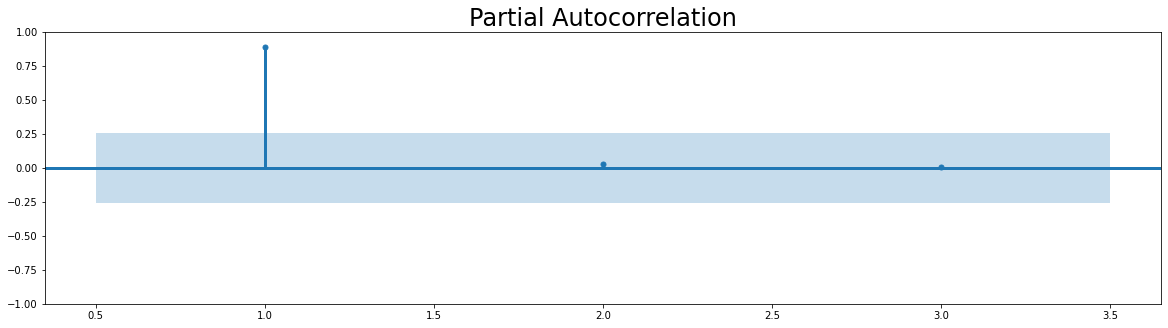

In [76]:
import statsmodels.graphics.tsaplots as sgt

plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(train_df.gdp, lags=3, method="ywm", zero=False)
plt.show()

Эти графики показывают, как данные коррелируют с запаздывающей версией самих себя.
В отличие от того, что предлагали графики ACF, цены SPX с лагом не приносят никакой новой информации. В таких ситуация параметр p выбирается =1


In [77]:
from statsmodels.tsa.stattools import adfuller

adfuller(train_df["gdp"])

(0.6529066974885355,
 0.9888496277665572,
 10,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 2194.301372914139)

In [78]:
test1 = adfuller(train_df["gdp"])
print("adf: ", test1[0])
print("p-value: ", test1[1])
print("Critical values: ", test1[4])
if test1[0] > test1[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  0.6529066974885355
p-value:  0.9888496277665572
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


Статистика теста больше всех критических значений, поэтому нулевую гипотезу ($H_0$) нельзя отвергнуть.

Поэтому цены SPX не являются стационарными

In [79]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0], lags=5)
    sgt.plot_pacf(series, ax=axes[1], lags=5, method="ywm")
    plt.show()

## Дифференцирование ряда
$y\_new_t = y_t - y_{t-1}$

where, 
- $y\_new_t$: Дифференцированное значение ряда $t$
- $y_t$: Фактическое значение ряда $t$
- $y_{t-1}$: Фактическое значение ряда $t-1$

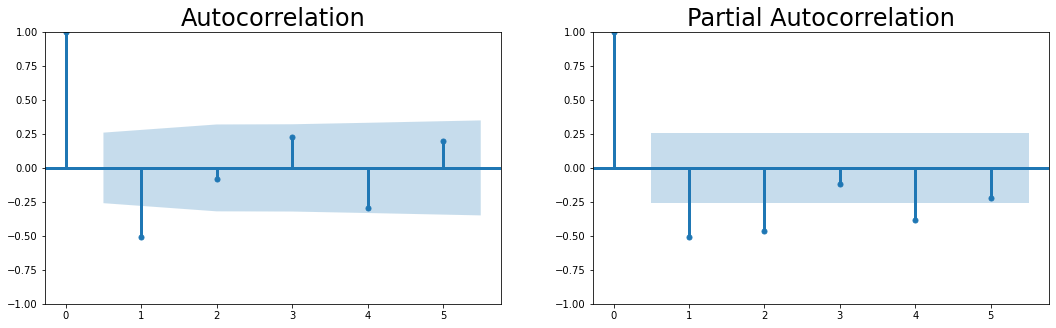

(-2.6408690561284858,
 0.08484116917837747,
 7,
 49,
 {'1%': -3.5714715250448363,
  '5%': -2.922629480573571,
  '10%': -2.5993358475635153},
 2102.755187953874)

In [80]:
plot_acf_pacf(train_df["gdp"].diff().diff().dropna())
adfuller(train_df["gdp"].diff().diff().dropna())

Первые разности являются стационарными

## ARIMA, SARIMA

Начнем построение модели **ARIMA** со следующими параметрами:

- p = 1 
- d = 1 
- q = 1 

Если рассматривать сезонную модель (**SARMA**), то в модель можно добавить следующие параметры.

- m = 5 (будучи рыночным индексом, данные, скорее всего, будут иметь еженедельно повторяющиеся паттерны, как видно из визуализации)
- P = 1 
- D = 1
- Q = 1 

Второй столбец раздела I содержит некоторые полезные показатели, которые используются для сравнения различных моделей ARIMA. Как правило, модель с более высоким логарифмическим правдоподобием или более низким IC (AIC, BIC или HQIC) лучше, и наоборот.

In [1]:
# pip install pmdarima
import pmdarima as pm

smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=1,
    start_q=1,
    max_p=3,
    max_q=3,
    D=1,
    start_P=0,
    m=5,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [71]:
smodel

ARIMA(order=(2, 1, 3), scoring_args={}, seasonal_order=(0, 1, 2, 5),
      suppress_warnings=True, with_intercept=False)

In [81]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

seas_model = SARIMAX(
    train_df["gdp"].dropna(), order=(2, 1, 3), seasonal_order=(0, 1, 2, 5)
)

seas_model_fit = seas_model.fit()
seas_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                    gdp   No. Observations:                   59
Model:             SARIMAX(2, 1, 3)x(0, 1, [1, 2], 5)   Log Likelihood               -1235.134
Date:                                Tue, 02 May 2023   AIC                           2486.267
Time:                                        10:44:05   BIC                           2502.030
Sample:                                    01-01-1960   HQIC                          2492.329
                                         - 01-01-2018                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4190      0.147     -2.853      0.004      -0.707      -0.131
ar.L2         -0.9991      0.192     -5.203      0.000      -1.375      -0.623
ma.L1          0.3684      0.243      1.519      0.129      -0.107       0.844
ma.L2          0.9226      0.214      4.313      0.000       0.503       1.342
ma.L3          0.4134      0.197      2.101      0.036       0.028       0.799
ma.S.L5        0.0399      0.270      0.148      0.883      -0.490       0.570
ma.S.L10      -0.4519      0.316     -1.431      0.152      -1.071       0.167
sigma2      1.363e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                73.51
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):              63.71   Skew:                             0.95
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.02e+54. Standard errors may be unstable.
"""

In [82]:
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = seas_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df["gdp"] = data["gdp"]

forecast = seas_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower gdp"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper gdp"]

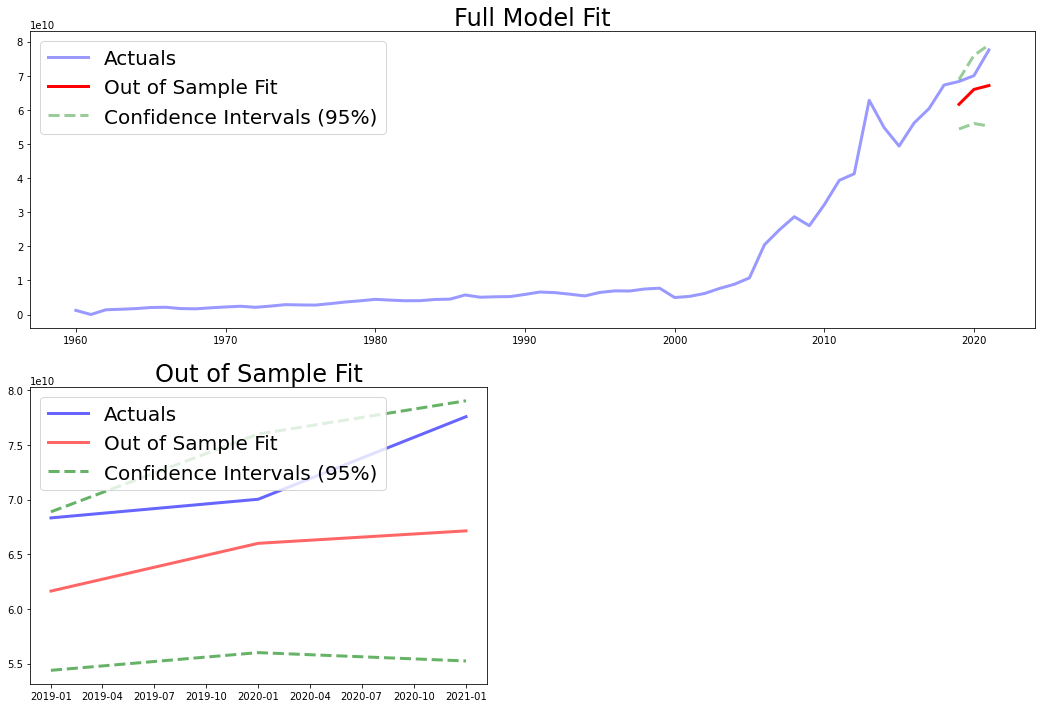

In [83]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["gdp"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["gdp"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

In [84]:
data.asfreq(freq='AS')

,gdp
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


In [88]:
import numpy as np
data['gdp'] = data['gdp'].apply(lambda x: np.nan if x==0 else x)

In [89]:
data.isna().sum()

gdp    1
dtype: int64

In [90]:
data = data.interpolate()
data.isna().sum()

gdp    0
dtype: int64

In [92]:
train_df = data.iloc[:-3]
test_df = data.iloc[-3:]
train_df.shape, test_df.shape

((59, 1), (3, 1))

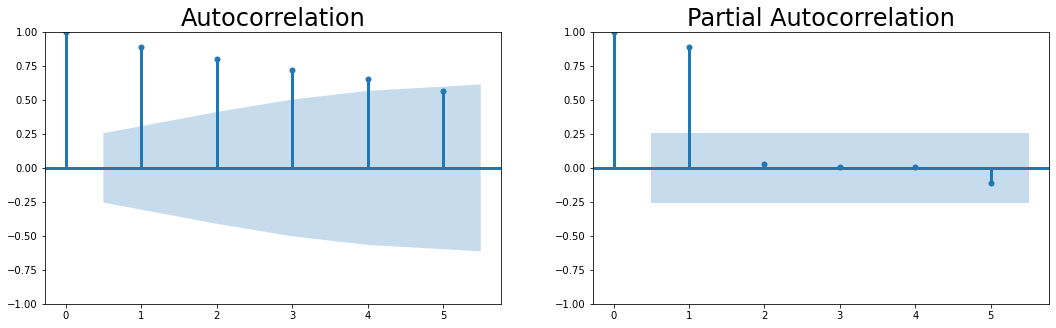

(0.8030073326980104,
 0.9916845572455877,
 10,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 2194.307284305165)

In [93]:
plot_acf_pacf(train_df["gdp"].dropna())
adfuller(train_df["gdp"].dropna())

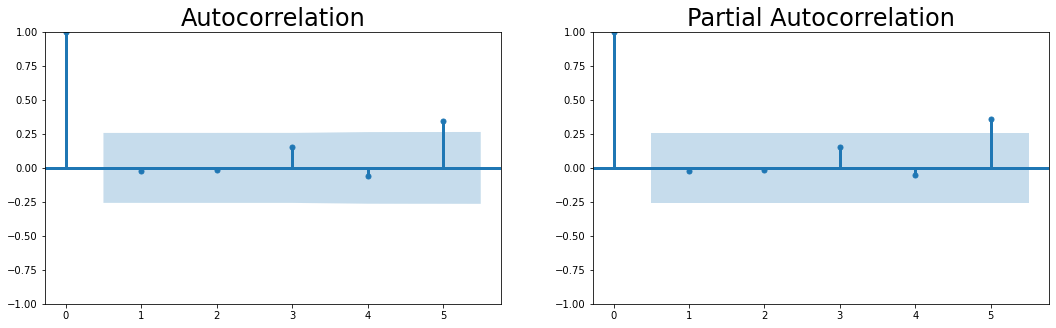

(-1.8255652246435998,
 0.36784515276563423,
 7,
 50,
 {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616},
 2147.2038799920597)

In [94]:
plot_acf_pacf(train_df["gdp"].diff().dropna())
adfuller(train_df["gdp"].diff().dropna())

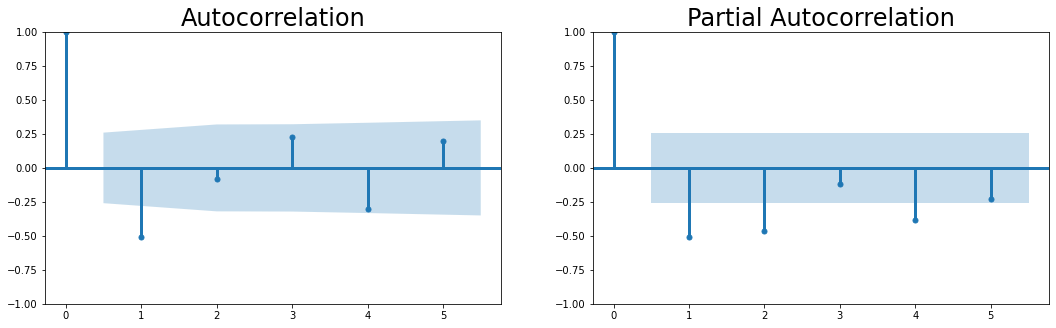

(-2.634634746007845,
 0.08604813722197624,
 7,
 49,
 {'1%': -3.5714715250448363,
  '5%': -2.922629480573571,
  '10%': -2.5993358475635153},
 2102.755187953874)

In [95]:
plot_acf_pacf(train_df["gdp"].diff().diff().dropna())
adfuller(train_df["gdp"].diff().diff().dropna())

In [84]:
import pmdarima as pm

smodel_i = pm.auto_arima(
    train_df,
    start_p=1,
    d=1,
    start_q=1,
    max_p=3,
    max_q=3,
    D=1,
    start_P=0,
    m=5,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel_i.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[5]             : AIC=2491.412, Time=0.23 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=2499.105, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=2493.664, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=2493.160, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[5]             : AIC=inf, Time=0.04 sec
 ARIMA(1,1,1)(1,1,1)[5]             : AIC=inf, Time=0.21 sec
 ARIMA(1,1,1)(0,1,2)[5]             : AIC=inf, Time=0.22 sec
 ARIMA(1,1,1)(1,1,0)[5]             : AIC=2492.573, Time=0.11 sec
 ARIMA(1,1,1)(1,1,2)[5]             : AIC=2495.412, Time=0.51 sec
 ARIMA(1,1,0)(0,1,1)[5]             : AIC=2492.391, Time=0.03 sec
 ARIMA(2,1,1)(0,1,1)[5]             : AIC=2489.992, Time=0.16 sec
 ARIMA(2,1,1)(0,1,0)[5]             : AIC=inf, Time=0.11 sec
 ARIMA(2,1,1)(1,1,1)[5]             : AIC=2491.982, Time=0.30 sec
 ARIMA(2,1,1)(0,1,2)[5]             : AIC=2491.973, Time=0.30 sec
 ARIMA(2,1,1)(1,1,0)[5]             : AIC=inf, Time=0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                   59
Model:             SARIMAX(2, 1, 3)x(0, 1, [1, 2], 5)   Log Likelihood               -1235.078
Date:                                Mon, 01 May 2023   AIC                           2486.156
Time:                                        18:22:24   BIC                           2501.918
Sample:                                             0   HQIC                          2492.217
                                                 - 59                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4164      0.136     -3.066      0.002      -0.683      -0.150
ar.L2         -0.9794      0.188     -5.202      0.000      -1.348      -0.610
ma.L1          0.3800      0.239      1.590      0.112      -0.089       0.849
ma.L2          0.9283      0.201      4.617      0.000       0.534       1.322
ma.L3          0.4421      0.186      2.378      0.017       0.078       0.807
ma.S.L5        0.0444      0.261      0.170      0.865      -0.468       0.557
ma.S.L10      -0.4442      0.318     -1.398      0.162      -1.067       0.179
sigma2      1.361e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                69.12
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):             181.21   Skew:                             0.87
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.67e+53. Standard errors may be unstable.
"""

In [85]:
smodel_i

ARIMA(order=(2, 1, 3), scoring_args={}, seasonal_order=(0, 1, 2, 5),
      suppress_warnings=True, with_intercept=False)

In [96]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

seas_model_i = SARIMAX(
    train_df["gdp"], order=(2, 1, 3), seasonal_order=(0, 1, 2, 5)
)

seas_model_i = seas_model_i.fit()
seas_model_i.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                    gdp   No. Observations:                   59
Model:             SARIMAX(2, 1, 3)x(0, 1, [1, 2], 5)   Log Likelihood               -1235.057
Date:                                Tue, 02 May 2023   AIC                           2486.115
Time:                                        10:44:58   BIC                           2501.877
Sample:                                    01-01-1960   HQIC                          2492.176
                                         - 01-01-2018                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4164      0.140     -2.984      0.003      -0.690      -0.143
ar.L2         -0.9821      0.190     -5.176      0.000      -1.354      -0.610
ma.L1          0.3811      0.241      1.578      0.114      -0.092       0.854
ma.L2          0.9261      0.201      4.604      0.000       0.532       1.320
ma.L3          0.4398      0.187      2.348      0.019       0.073       0.807
ma.S.L5        0.0433      0.264      0.164      0.870      -0.474       0.561
ma.S.L10      -0.4437      0.320     -1.386      0.166      -1.071       0.184
sigma2      1.361e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                70.37
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):             181.00   Skew:                             0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.72e+54. Standard errors may be unstable.
"""

In [97]:
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = seas_model_i.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df["gdp"] = data["gdp"]

forecast = seas_model_i.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower gdp"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper gdp"]

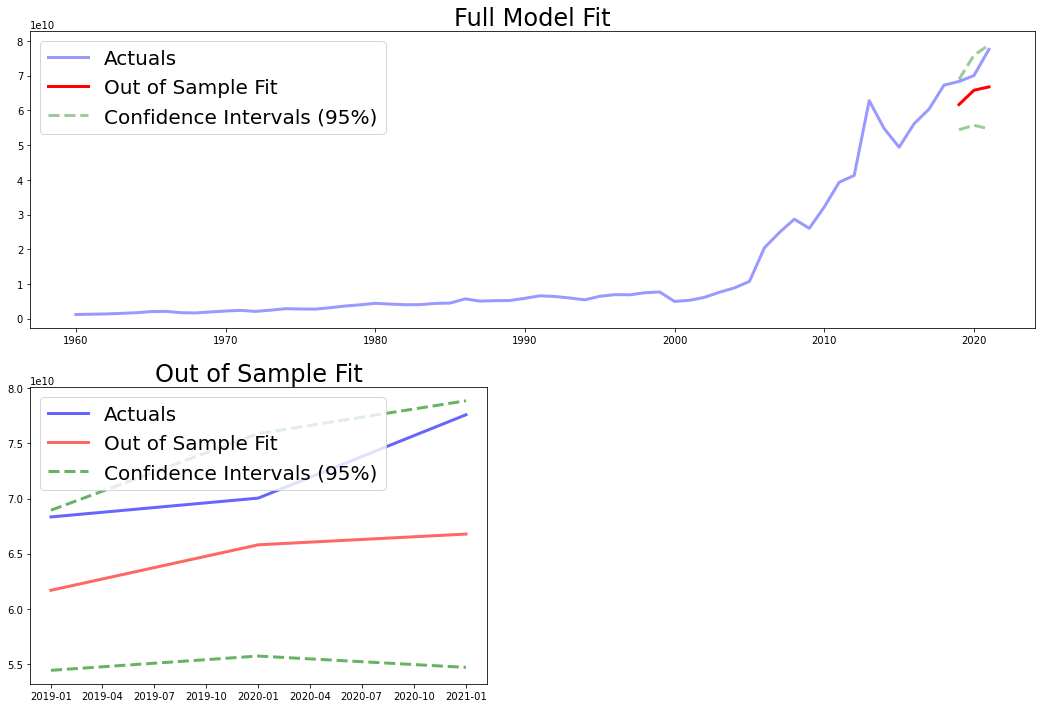

In [98]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["gdp"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["gdp"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

In [99]:
seas_model_fit.aic - seas_model_i.aic

0.15236690844267287

In [101]:
data['gdp_vol'] = (data.gdp - data.gdp.shift(1))/data.gdp.shift(1)
data['gdp_vol'] = data.gdp.pct_change(1).mul(100).abs()
data['gdp_vol'].head()

year
1960-01-01          NaN
1961-01-01     6.789413
1962-01-01     6.357759
1963-01-01    11.448835
1964-01-01    12.363636
Name: gdp_vol, dtype: float64

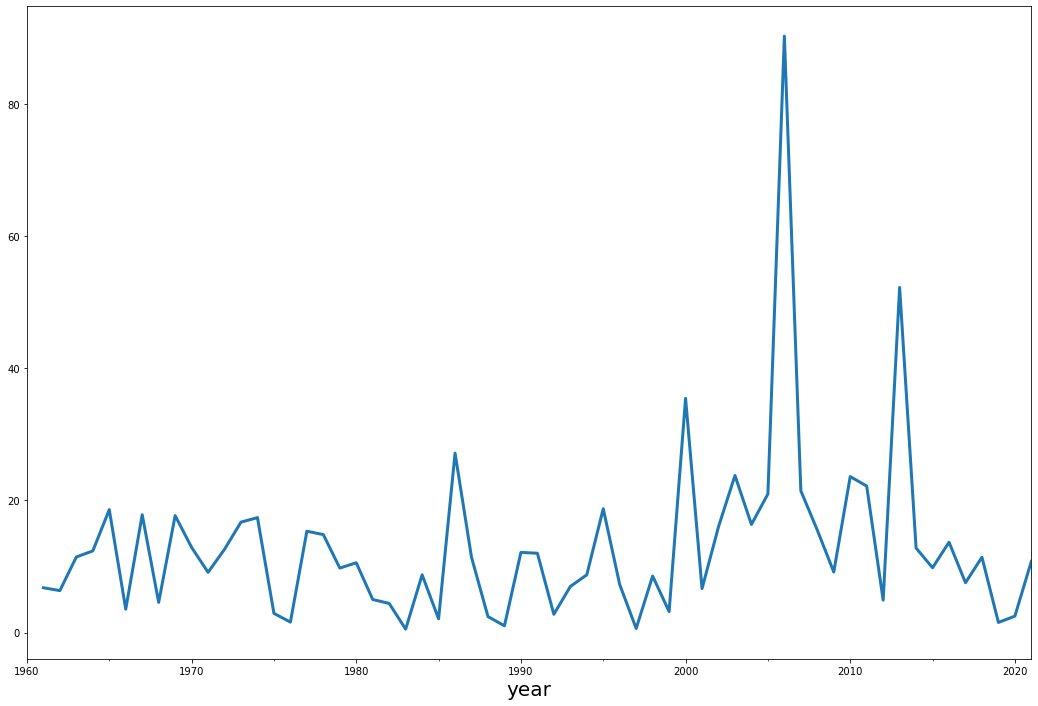

In [102]:
data['gdp_vol'].plot()
plt.show()

In [103]:
train_df = data.iloc[:-3]
test_df = data.iloc[-3:]
train_df.shape, test_df.shape

((59, 2), (3, 2))

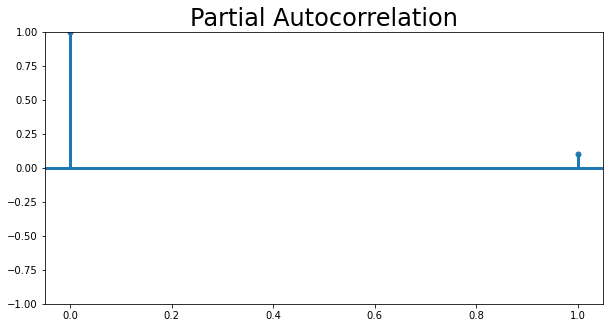

In [116]:
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = 10, 5

sgt.plot_pacf(train_df.gdp_vol[1:], lags=1 , method="ywm")
plt.show()

In [118]:
adfuller(train_df.gdp_vol[1:])

(-6.725311059553777,
 3.4014596148856737e-09,
 0,
 57,
 {'1%': -3.5506699942762414,
  '5%': -2.913766394626147,
  '10%': -2.5946240473991997},
 382.739595975669)

In [147]:
# нам важно сохранить объем датасета, поэтому берем за исходные данные весь датасет с индексами, который содержит
# и train и test часть
garch_df = pd.DataFrame(data['gdp_vol'].loc[data.index])

# далее необходимо использовать актуальные обучающие данные, которые находятся в выборке train_df.
# Мы никак не преобразовывали нашу обучющую выборку, поэтому фактически, train_df совпадает с данными в data,
# Но если вы применяете к вашей обечающей выборке какие либо преобразования, например скользящее среднее
# для сглаживания, то необходимо передать измененный train_df датасет.

garch_df.loc[train_df.index, 'gdp_vol'] = train_df['gdp_vol'].dropna()

In [152]:
from arch import arch_model

model = arch_model(garch_df['gdp_vol'].dropna())

# в параметре last_obs указываем последний объект, до которого будем совершать обучение.
# в нашем случае это до первого объекта из test выборки
model_results = model.fit(last_obs=test_df.index[0], update_freq=5)

Iteration:      5,   Func. Count:     27,   Neg. LLF: 251.188178964797
Iteration:     10,   Func. Count:     57,   Neg. LLF: 4850.7687325411935
Iteration:     15,   Func. Count:     89,   Neg. LLF: 228.0018562906664
Iteration:     20,   Func. Count:    114,   Neg. LLF: 226.59783341423395
Optimization terminated successfully    (Exit mode 0)
            Current function value: 226.59781233064342
            Iterations: 22
            Function evaluations: 123
            Gradient evaluations: 22


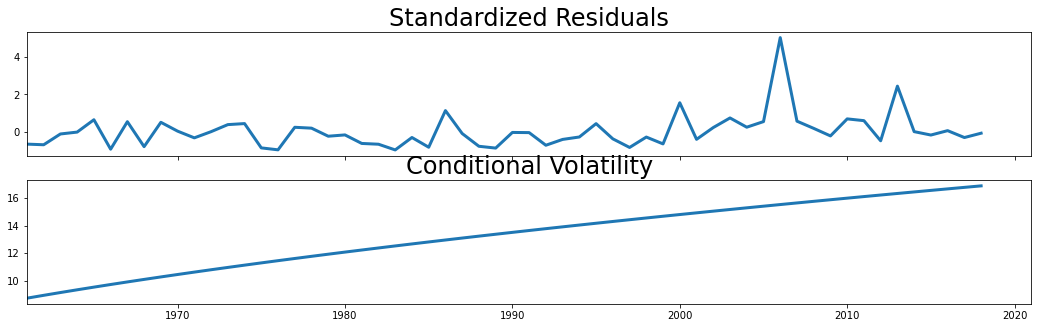

In [157]:
fig = model_results.plot()

In [158]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                gdp_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -226.598
Distribution:                  Normal   AIC:                           461.196
Method:            Maximum Likelihood   BIC:                           469.437
                                        No. Observations:                   58
Date:                Tue, May 02 2023   Df Residuals:                       57
Time:                        11:01:22   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            12.3191      2.572      4.791  1.663e-06 [  7.279, 17.359]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          3.6700     24.737      0.148      0.882 [-44.814, 52.154]
alpha[1]       0.0000  9.201e-02      0.000      1.000 [ -0.180,  0.180]
beta[1]        1.0000      0.157      6.384  1.723e-10 [  0.693,  1.307]
========================================================================

Covariance estimator: robust
"""

In [163]:
predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[
    test_df.index
]

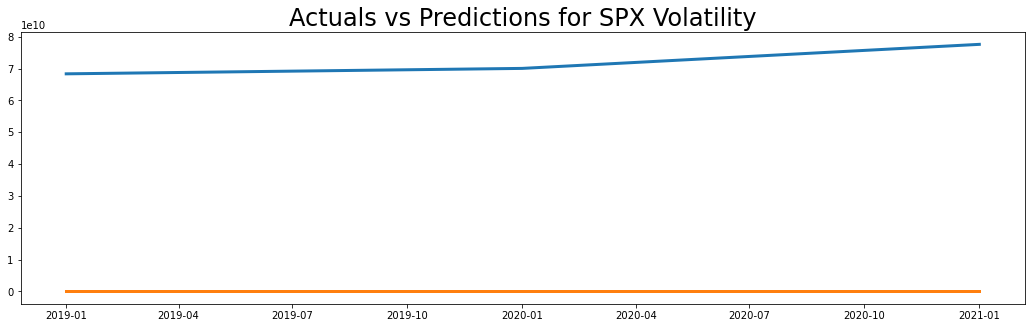

In [164]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(predictions_df["gdp"].abs())

plt.plot(predictions_df["Predictions"])

plt.title("Actuals vs Predictions for SPX Volatility", size=24)

plt.show()

In [165]:
import numpy as np
from sklearn.metrics import mean_squared_error

mean_squared_error(
    predictions_df["gdp_vol"].abs(), predictions_df["Predictions"]
)

82530.23681078723

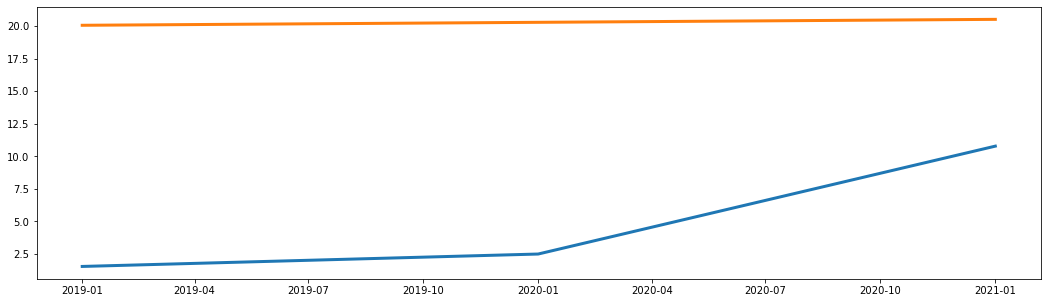

In [166]:
from sklearn.linear_model import LinearRegression

X_train = pd.DataFrame(range(data["gdp_vol"].shape[0]))[
    : train_df.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(data["gdp_vol"].shape[0]))[
    train_df.shape[0] :
].fillna(0)
y_train = train_df["gdp_vol"].fillna(0)
y_test = test_df["gdp_vol"].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)


plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))
plt.show()